# Groeps Opdracht CI
## Joost Vledder, Sadjia Safdari, Simon Kreulen & Jasper van Eck

### Inhoudsopgave <a name='Top'></a>

[Imports](#import)

[Load data](#loaddata)

[Data Clean Up](#cleanup)

[Basic Data Stats](#basicdata)

[Plots](#plots)

### Imports <a name='import'></a>

[Top](#Top)

In [1]:
import os
import pandas as pd
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import matplotlib.pyplot as plt
from collections import defaultdict

### Load data <a name='loaddata'></a>

[Top](#Top)

In [2]:
#rootdir = './yelp/data'
rootdir = './yelp/data/toronto'

df_business = pd.DataFrame()
df_users = pd.DataFrame()
df_reviews = pd.DataFrame()

count = 0

for subdir, dirs, files in os.walk(rootdir):
    if count == 200: #1078 is the total amount of cities
        break
        
    for file in files:
        if os.path.basename(file) == 'business.json':
            df_business = df_business.append(pd.read_json(os.path.join(subdir, file),lines=True))
        if os.path.basename(file) == 'user.json':
            df_users = df_users.append(pd.read_json(os.path.join(subdir, file),lines=True))
        if os.path.basename(file) == 'review.json':
            df_reviews = df_reviews.append(pd.read_json(os.path.join(subdir, file),lines=True))
    count += 1

df_business = df_business.set_index('business_id')
df_users = df_users.set_index('user_id')
df_reviews = df_reviews.set_index('review_id')

display(df_business.head())
display(df_users.head())
display(df_reviews.head())

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
business_id,,,,,,,,,,,,,
zSpQmEBvRe3IhTUlMSA6HQ,Totum Life Science,"445 King Street W, Suite 101",Toronto,ON,M5V 1K4,43.645041,-79.395799,4.0,23,1,"{'AcceptsInsurance': 'True', 'ByAppointmentOnl...","Trainers, Health & Medical, Active Life, Physi...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,"865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5,8,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","Bakeries, Food","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
C9keC4mWuXdl2mYFHZXudQ,Uncle Otis Clothing,26 Bellair St,Toronto,ON,M5R 2C7,43.670744,-79.391385,5.0,12,1,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","Fashion, Sporting Goods, Men's Clothing, Shopp...","{'Monday': '11:30-19:0', 'Tuesday': '11:30-19:..."
NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': 'u'no'', 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ..."
SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0..."


,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
user_id,,,,,,,,,,,,,,,,,,,,,
gvXtMj3XuPr0xHjgmlmtng,Peter,47,2014-01-05 20:45:54,57,26,34,"2017,2018","CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA...",9,3.60,...,0,0,0,0,4,11,5,5,4,3
pU6GoRTcl1rIOi6zMynjog,Javier,470,2011-12-16 16:13:01,1655,1007,974,"2015,2016,2017,2018","tRC9YLo4LHquMVXZ9VO4Ag, -YpfTgz88rsPwsOvlfKn7w...",71,3.45,...,8,1,0,0,42,32,64,64,35,10
_ICqwy7SW8J6OJBab1HkwA,allison,391,2007-10-06 02:42:28,708,316,399,"2008,2009","o8H8CioXzL4ZR_zxZYcv3Q, yJB1hHDIq18Qvmo3yo9_KA...",13,4.31,...,6,3,5,4,21,39,23,23,8,1
rnU1EFMSnVJGrQxrnjaODg,Fred,431,2010-12-28 01:37:20,3157,1338,2158,"2014,2015,2016,2017,2018","HHmX2L4Gg6L0WJNcxs4Ptw, 8DEyKVyplnOcSKx39vatbg...",58,3.95,...,22,3,1,0,163,118,201,201,58,112
AsYMm_O4H-mwmWbmeACDHw,Christopher,318,2015-01-17 17:04:09,400,175,223,"2016,2017,2018","4I_AqfW1E_OLDskrgxxU0Q, 0hm1__RgRWYvHXxWfUJMyA...",24,3.64,...,4,1,0,0,2,4,4,4,2,5


,user_id,business_id,stars,useful,funny,cool,text,date
review_id,,,,,,,,
JVcjMhlavKKn3UIt9p9OXA,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1,1,1,0,I cannot believe how things have changed in 3 ...,2012-07-16 00:37:14
svK3nBU7Rk8VfGorlrN52A,NJlxGtouq06hhC7sS2ECYw,YvrylyuWgbP90RgMqZQVnQ,5,0,0,0,You can't really find anything wrong with this...,2017-04-07 21:27:49
4bUyL7lzoWzDZaJETAKREg,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3,0,0,0,Good selection of classes of beers and mains. ...,2014-06-27 21:19:23
E6B-2U2sGG3xgmnNWZAEew,DbccYu3OppWKl21OanZnTg,YSUcHqlKMPHHJ_cTrqtNrA,1,0,0,0,Came here on a Thursday night at 6:30 p.m. My ...,2017-12-29 13:55:19
0NRNA8qIq9nKw5FcwyOxcQ,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4,0,0,0,Very nice eating environment and the food are ...,2015-04-01 13:31:35


In [3]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [4]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

In [5]:
display(df_business)
display(df_users)
display(df_reviews)

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
business_id,,,,,,,,,,,,,
zSpQmEBvRe3IhTUlMSA6HQ,Totum Life Science,"445 King Street W, Suite 101",Toronto,ON,M5V 1K4,43.645041,-79.395799,4.0,23,1,"{'AcceptsInsurance': 'True', 'ByAppointmentOnl...","Trainers, Health & Medical, Active Life, Physi...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,"865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5,8,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","Bakeries, Food","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
C9keC4mWuXdl2mYFHZXudQ,Uncle Otis Clothing,26 Bellair St,Toronto,ON,M5R 2C7,43.670744,-79.391385,5.0,12,1,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","Fashion, Sporting Goods, Men's Clothing, Shopp...","{'Monday': '11:30-19:0', 'Tuesday': '11:30-19:..."
NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': 'u'no'', 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ..."
SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5XwfpotCAvDzPyAulk_m5A,Starbucks,1 Adelaide St E,Toronto,ON,M5C 2V9,43.650161,-79.377797,3.5,6,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsPri...","Coffee & Tea, Food",None
_mo-QIcmJgUwcjeunAwtew,Espinosa Master Tailor,"221 Davenport Rd Toronto, ON M5R IJ3, Unit 9",Toronto,ON,M4W 1J5,43.674761,-79.395690,4.0,6,1,"{'RestaurantsPriceRange2': '3', 'WheelchairAcc...","Professional Services, Men's Clothing, Shoppin...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
lo8WwqKogC-kz4toRvkdUQ,KOKO! Share Bar,81 Yorkville Avenue,Toronto,ON,M5R 1C1,43.670948,-79.391502,3.5,47,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'f...","Korean, Japanese, Asian Fusion, Restaurants","{'Monday': '11:30-22:30', 'Tuesday': '11:30-22..."


,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
user_id,,,,,,,,,,,,,,,,,,,,,
gvXtMj3XuPr0xHjgmlmtng,Peter,47,2014-01-05 20:45:54,57,26,34,"2017,2018","CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA...",9,3.60,...,0,0,0,0,4,11,5,5,4,3
pU6GoRTcl1rIOi6zMynjog,Javier,470,2011-12-16 16:13:01,1655,1007,974,"2015,2016,2017,2018","tRC9YLo4LHquMVXZ9VO4Ag, -YpfTgz88rsPwsOvlfKn7w...",71,3.45,...,8,1,0,0,42,32,64,64,35,10
_ICqwy7SW8J6OJBab1HkwA,allison,391,2007-10-06 02:42:28,708,316,399,"2008,2009","o8H8CioXzL4ZR_zxZYcv3Q, yJB1hHDIq18Qvmo3yo9_KA...",13,4.31,...,6,3,5,4,21,39,23,23,8,1
rnU1EFMSnVJGrQxrnjaODg,Fred,431,2010-12-28 01:37:20,3157,1338,2158,"2014,2015,2016,2017,2018","HHmX2L4Gg6L0WJNcxs4Ptw, 8DEyKVyplnOcSKx39vatbg...",58,3.95,...,22,3,1,0,163,118,201,201,58,112
AsYMm_O4H-mwmWbmeACDHw,Christopher,318,2015-01-17 17:04:09,400,175,223,"2016,2017,2018","4I_AqfW1E_OLDskrgxxU0Q, 0hm1__RgRWYvHXxWfUJMyA...",24,3.64,...,4,1,0,0,2,4,4,4,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BV2d_An-rH-ZFzHzUKPvtw,Lyle,1,2015-03-21 00:22:39,2,0,0,,None,0,5.00,...,0,0,0,0,0,0,0,0,0,0
3FtrfFF9Szc7GmouPnLMbw,Bonnie,2,2010-06-18 18:07:17,2,0,1,,None,0,3.00,...,0,0,0,0,0,0,0,0,0,0
EaJwngi2_naAJVPIbPRUNg,Daniel,1,2015-10-04 19:45:51,0,0,0,,None,0,5.00,...,0,0,0,0,0,0,0,0,0,0


,user_id,business_id,stars,useful,funny,cool,text,date
review_id,,,,,,,,
JVcjMhlavKKn3UIt9p9OXA,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1,1,1,0,I cannot believe how things have changed in 3 ...,2012-07-16 00:37:14
svK3nBU7Rk8VfGorlrN52A,NJlxGtouq06hhC7sS2ECYw,YvrylyuWgbP90RgMqZQVnQ,5,0,0,0,You can't really find anything wrong with this...,2017-04-07 21:27:49
4bUyL7lzoWzDZaJETAKREg,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3,0,0,0,Good selection of classes of beers and mains. ...,2014-06-27 21:19:23
E6B-2U2sGG3xgmnNWZAEew,DbccYu3OppWKl21OanZnTg,YSUcHqlKMPHHJ_cTrqtNrA,1,0,0,0,Came here on a Thursday night at 6:30 p.m. My ...,2017-12-29 13:55:19
0NRNA8qIq9nKw5FcwyOxcQ,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4,0,0,0,Very nice eating environment and the food are ...,2015-04-01 13:31:35
...,...,...,...,...,...,...,...,...
Io0vyvmbFh3H0lpa7Es54A,edp649wUqcjv8ckzztzssg,onCx6Ye5IwD07emyj-VLrg,1,0,0,0,A friend had heard amazing things about Hogtow...,2018-11-05 23:02:24
DfP922JY3H4EhkpXgyxy5A,YBT3EKUNN4IP8m4x7sGu1g,_2ql5K9XZDk0lYiEgdmlLg,5,3,0,1,"4.5 - 5 STARS.\nTiny place, hidden away in the...",2018-11-03 20:22:27
40HV3Lh2Mn2InTmT8VIzIg,gEfP-xd8fFAwJ877cH4biQ,RBMESPbQp29FnGA5Dpu1Tg,5,1,0,0,I brought my daughter's Toyota Sienna there to...,2014-10-15 07:54:20


### Clean up Data For Content Based <a name='cleanup'></a>

[Top](#Top)

In [6]:
cat_dict = defaultdict(lambda: defaultdict(int))

# Drop na categories
df_business = df_business[df_business['categories'].notna()]

# Normalize long, lat, stars & review_count
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
df_business['stars'] = (df_business['stars']-df_business['stars'].min()) / (df_business['stars'].max()-df_business['stars'].min())
df_business['review_count'] = (df_business['review_count']-df_business['review_count'].min()) / (df_business['review_count'].max()-df_business['review_count'].min())
df_business['x_axis'] = np.cos(df_business['latitude']) * np.cos(df_business['longitude'])
df_business['y_axis'] = np.cos(df_business['latitude']) * np.sin(df_business['longitude'])

# Dataframe of categories one hot encoded per business_id
df_tmp = df_business['categories'].str.split(pat=', ',expand=True)

# Create dict of categories
for index, row in df_tmp.iterrows():
    for _,elem in row.items():
        if elem and elem not in cat_dict[index]:
            cat_dict[index][elem] += 1  

In [7]:
# Create DF from dict
df_cats = pd.DataFrame.from_dict(cat_dict, orient='index')

#Drop NaN column
df_cats = df_cats.drop(columns='NaN',errors='ignore')

# Fillna with 0
df_cats = df_cats.fillna(0)

# Join back into business
df_business = df_business.join(df_cats,on='business_id')

# Drop cols
df_business = df_business.drop(columns=['address','city','state','postal_code','latitude','longitude','attributes','categories','hours'],errors='ignore')

# Remove elite & friends columns because of non use
df_users = df_users.drop(columns=['elite','friends'],axis=1,errors='ignore')

In [8]:
display(df_business.head())

,name,stars,review_count,is_open,x_axis,y_axis,Trainers,Health & Medical,Active Life,Physical Therapy,...,Float Spa,Dietitians,Izakaya,Shredding Services,Retirement Homes,Boat Repair,Kitchen Supplies,Public Art,Grilling Equipment,Editorial Services
business_id,,,,,,,,,,,,,,,,,,,,,
zSpQmEBvRe3IhTUlMSA6HQ,Totum Life Science,0.750,0.009443,1,-0.618552,0.712671,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,0.875,0.002361,1,-0.671812,0.705329,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9keC4mWuXdl2mYFHZXudQ,Uncle Otis Clothing,1.000,0.004249,1,-0.627088,0.716097,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,0.500,0.025496,1,-0.596714,0.730130,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,0.625,0.012276,0,-0.595418,0.738543,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [10]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Basic Data Stats for Content Based <a name='basicdata'></a>

[Top](#Top)

In [11]:
# Some information about the category amounts per business

# series of amount of categories per business
cats_business = df_cats.sum(axis=1)
display(cats_business)

avg_cats_bus = cats_business.mean()
max_cats_bus = cats_business.max()
min_cats_bus = cats_business.min()

print('Average amount of categories for businesses: ', avg_cats_bus)
print('Minimum amount of categories for businesses: ', min_cats_bus)
print('Maximum amount of categories for businesses: ', max_cats_bus)

# series of amount of businesses with the index amount of categories
cat_bus_distribution = cats_business.value_counts()
display(cat_bus_distribution)

zSpQmEBvRe3IhTUlMSA6HQ    6.0
b7zt8LVQ9RfFbDL5YXYz_Q    8.0
qcb9ypJtmbiEQg65uaCwqA    6.0
JVM5t8uycU_MNZnpzjLilQ    8.0
Ngk84Ax1tXgpoJFEGxot3w    6.0
                         ... 
WhZk6DnsyuYrn2TTIgKsAg    2.0
kvUmiPg2g5d0OrsMiBZScg    2.0
qr7vNlqoCYSTZ_iNOdXbFQ    2.0
wtSP0_BZfS5bYaFMp8NPfw    2.0
07o0aA2GNxvSxM6bkkBsAA    2.0
Length: 18881, dtype: float64

Average amount of categories for businesses:  3.877019225676606
Minimum amount of categories for businesses:  1.0
Maximum amount of categories for businesses:  18.0


2.0     5519
3.0     4159
4.0     3277
5.0     2443
6.0     1525
7.0      848
8.0      468
9.0      257
10.0     127
1.0      109
11.0      62
12.0      32
13.0      22
14.0      15
15.0      12
16.0       3
17.0       2
18.0       1
dtype: int64

In [12]:
# series of number of businesses with index as category
cats_presences = df_cats.sum(axis=0).sort_values(ascending=False)
display(cats_presences)

avg_cats = cats_presences.mean()
max_cats = cats_presences.max()
min_cats = cats_presences.min()

Restaurants           7965.0
Food                  4182.0
Shopping              3174.0
Beauty & Spas         1952.0
Nightlife             1721.0
                       ...  
RV Rental                1.0
Balloon Services         1.0
Laboratory Testing       1.0
Nanny Services           1.0
Editorial Services       1.0
Length: 909, dtype: float64

### Plots <a name='plots'></a>

[Top](#Top)

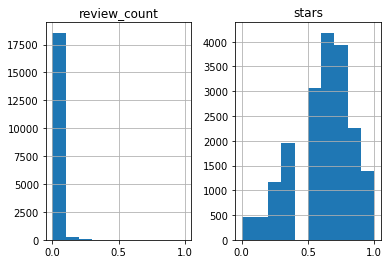

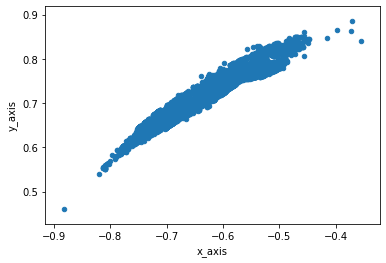

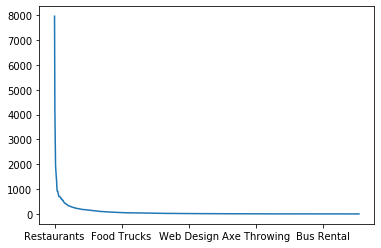

In [13]:
hist_bus = df_business.hist(column=['stars','review_count'])
df_business.plot(x='x_axis',y='y_axis',kind='scatter')
plt.show()
cats_presences.plot()

### Basic Data Stats for Collaborative Based <a name='basicdata'></a>

[Top](#Top)

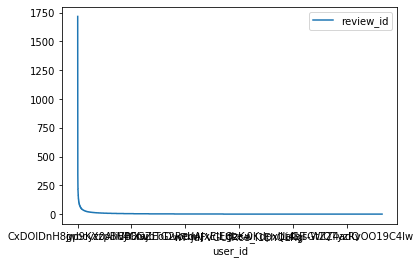

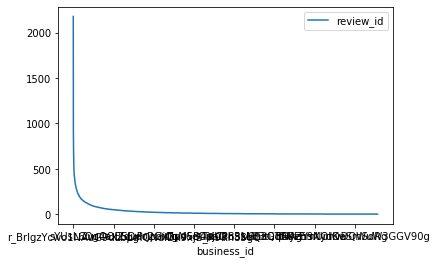

In [14]:
# reset index
df_reviews = df_reviews.reset_index()

# count reviews per user and reviews per business
reviews_per_user = df_reviews.groupby("user_id")["review_id"].count().sort_values(ascending=False).to_frame()
reviews_per_business = df_reviews.groupby("business_id")["review_id"].count().sort_values(ascending=False).to_frame()


# plot both review counts
user_plot = reviews_per_user.plot()
business_plot = reviews_per_business.plot()

### Utility Matrix <a name='utilitymatrix'></a>

[Top](#Top)

In [ ]:
df_reviews = df_reviews[:10000]
df_reviews

In [ ]:
def pivot_ratings(ratings):
    pivottable = ratings.pivot_table(index="business_id", columns="user_id", values="stars").fillna(0)
    return pivottable

utility_matrix = pivot_ratings(df_reviews)
display(utility_matrix)

In [ ]:
utility_matrix.to_pickle('./utility_pickle.pkl')
utility_matrix_toronto = pd.read_pickle('./utility_pickle.pkl')

In [ ]:
display(utility_matrix_toronto)

### Similarity Matrix <a name='utilitymatrix'></a>

[Top](#Top)

In [ ]:
def cosine_distance(matrix, id1, id2):
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]
    
    if id1 == id2:
        return 1.
    
    sim = (np.sqrt(sum(features1**2))*np.sqrt(sum(features2**2)))
    
    if sim == 0.:
        return np.nan
    
    return sum(features1*features2)/sim

def create_similarity_matrix_cosine(matrix):
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index, i] = cosine_distance(matrix, index, i)
    
    return similarity_matrix
    
similarity = create_similarity_matrix_cosine(utility_matrix_toronto)
display(similarity)

In [ ]:
def mean_center_columns(matrix):
    return matrix.apply(lambda x: x - x.mean())

centered_utility_matrix = mean_center_columns(utility_matrix)
display(centered_utility_matrix)

similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

In [ ]:
# TEST neighborhood op eentje

def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    moviesNotWatched = ratings[ratings.isna()].index
    
    similarities = similarities.where(lambda x : x > 0.00).dropna()
    similarities = similarities.drop(labels = moviesNotWatched)
    
    return similarities
    

neighborhood = select_neighborhood(similarity["6E5SM3-YvBpdzNNW68ksTw"], utility_matrix["-1B9xAQxWufCB3ksliPxZA"], 10)
display(neighborhood)

In [ ]:
# TEST

def weighted_mean(neighborhood, ratings):  
    upper = 0
    bottom = 0
    
    for index in neighborhood.index:
        similarity = neighborhood.get(index)
        upper += ratings.get(index) * similarity
        bottom += similarity
    
    if bottom == 0:
        return np.nan
    else:
        return upper / bottom

neighborhood1 = select_neighborhood(similarity["6E5SM3-YvBpdzNNW68ksTw"], utility_matrix["-1B9xAQxWufCB3ksliPxZA"], 10)
prediction1 = weighted_mean(neighborhood1, utility_matrix["-1B9xAQxWufCB3ksliPxZA"])

neighborhood2 = select_neighborhood(similarity["UM07j7HtW-dhr8Gq3LQLxg"], utility_matrix["-1B9xAQxWufCB3ksliPxZA"], 10)
prediction2 = weighted_mean(neighborhood1, utility_matrix["-1B9xAQxWufCB3ksliPxZA"])

In [ ]:
"""""
userplot --> the distribution of the reviews over the users (long-tail): considering the fact that there are more
reviews on business than users (one user can rate more than 1 business), it is probably better to choose
item-based CF than user-based CF. 

"""""
users_series = df_users['review_count'].sort_values(ascending=False).drop_duplicates(keep='first')

display(users_series)
userplot = users_series.plot()

userplot.set(xlabel='user_id', ylabel='review_count')
plt.show()

In [ ]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_cats = pd.read_pickle('./cats_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Cosine Similarity <a name='cossim'></a>

[Top](#Top)

In [ ]:
# Input vectors are series, convert to np array
def cosineSim(vector, docVector):
    vector = vector.to_numpy()
    docVector = docVector.to_numpy()
    
    # Get lengths of vectors
    sim = (np.sqrt(sum(vector**2))*np.sqrt(sum(docVector**2)))
    
    # Ensure no division by 0
    if sim == 0.:
        return np.nan
    
    # Calculate cosine sim
    return vector.dot(docVector)/sim

In [ ]:
def rankedBusinessList(df_business, queryVector):
    df_bus_features = df_business.copy().drop(columns=['name','city','stars','review_count','is_open','Score Cos'],errors='ignore')
    scoreList = np.zeros(len(df_business))
    for i in range(len(df_bus_features)):
        scoreList[i] = cosineSim(queryVector, df_bus_features.iloc[i])
    
    df_business['Score Cos'] = scoreList
    return df_business.sort_values(by=['Score Cos','stars'],ascending=False)

### Create Query Vector <a name='queryvector'></a>

[Top](#Top)

This first cell get the longitude and latitude of a given city and state, and normalizes both values.

In [ ]:
loc_string = 'Las Vegas NV'
gn = Nominatim(user_agent='WalterGKurtz')
location = gn.geocode(loc_string)
queryVector = pd.Series(data=0.,index=df_business.columns)
queryVector.at['latitude'] = location.latitude
queryVector.at['longitude'] = location.longitude
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
#queryVector.at['x_axis'] = np.cos(location.latitude) * np.cos(location.longitude)
#queryVector.at['y_axis'] = np.cos(location.latitude) * np.sin(location.longitude)


The second cell inputs the preferences of the user.

In [ ]:
# Preferences
queryVector = queryVector.drop(labels=['name','city','stars','review_count','is_open'],errors='ignore')
queryVector.at['Automotive'] = 0
queryVector.at['Auto Repair'] = 0
queryVector.at['Fast Food'] = 0
queryVector.at['Restaurants'] = 0
queryVector.at['Pizza'] = 1.
queryVector.at['Men\'s Clothing'] = 0
queryVector.at['Women\'s Clothing'] = 0
queryVector.at['Fashion'] = 0
queryVector.at['Bars'] = 0
display(queryVector)
#queryVector.to_csv('test.csv', header=False)

In [ ]:
display(rankedBusinessList(df_business,queryVector).head(20))

### SVD <a name='svd'></a>

[Top](#Top)

In [ ]:
stars = df_business['stars'].values
cities = df_business['city'].values
names = df_business['name'].values
bus_ids = df_business.index
df_tmp_svd = df_business.copy().drop(columns=['name','city', 'stars','review_count','is_open', 'Score Cos'],errors='ignore').to_numpy()

In [ ]:
# This code can be used to find the optimal amount of dimension by the SVD

# trunc_svd = TruncatedSVD(n_components=len(df_tmp_svd[0])-1).fit(df_tmp_svd)
# reduced_x = trunc_svd.transform(df_tmp_svd)
# singles = trunc_svd.singular_values_

# eigvals = singles**2 / np.sum(singles**2)
# fig = plt.figure(figsize=(8,5))
# sing_vals = np.arange(len(df_tmp_svd[0])-1) + 1
# plt.plot(sing_vals[2:200], eigvals[2:200], 'ro-', linewidth=2)
# plt.title('Scree Plot')
# plt.xlabel('Component number')
# plt.ylabel('Eigenvalue')
# plt.show()

In [ ]:
optimal_dims = 25
trunc_svd = TruncatedSVD(n_components=optimal_dims).fit(df_tmp_svd)
reduced_x = trunc_svd.transform(df_tmp_svd)

In [ ]:
queryVectorReduced = trunc_svd.transform(np.array([queryVector]))

df_reduced_x = pd.DataFrame(data=reduced_x, index=bus_ids)
df_reduced_x.insert(0, 'stars', stars)
df_reduced_x.insert(0, 'city', cities)
df_reduced_x.insert(0, 'name', names)
df_queryVectorReduced = pd.Series(data=queryVectorReduced[0])
display(rankedBusinessList(df_reduced_x,df_queryVectorReduced).head(20))

### K-means <a name='kmeans'></a>

[Top](#Top)

In [ ]:
# # This block of code was used to find the optimal K, it takes very long to run, so that's why it is commented now.

# from yellowbrick.cluster import KElbowVisualizer

# df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()

# # choose k

# model = KMeans(random_state=0)
# visualizer = KElbowVisualizer(model, k=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
# visualizer.fit(df_bus_kmeans)        # Fit the data to the visualizer
# visualizer.show() 

In [ ]:
df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()
kmeans = KMeans(n_clusters=300,random_state=0).fit(df_bus_kmeans)

In [ ]:
# Predict query vector
labels = np.array(kmeans.predict(df_bus_kmeans))
prediction = kmeans.predict([df_queryVectorReduced.to_numpy()])

matches = [y[0] for y,val in np.ndenumerate(labels) if val == prediction]

df_matched = df_business.iloc[matches]

display(df_matched.sort_values(by=['stars'],ascending=False).head(20))

### Cohen's Kappa <a name='cohenkappa'></a>

[Top](#Top)

In [ ]:
# Dataformat
# 1 | 0
# 1 | 1
# 0 | 1

def PE(data):
    '''On input data, return the P(E) (expected agreement).'''
    relevant = 0
    nonrelevant = 0
    # Iterate over the data
    for i in data:
        for j in i:
            
            # Top up the relevant documents by one if 1 is encountered
            if j == 1:
                relevant += 1
            # Top up the nonrelevant documents by one if 0 is encountered
            if j == 0:
                nonrelevant += 1

    # Calculates the total of inspected documents for the judges combined
    total = len(data)*2

    # Calculates the pooled marginals
    rel = relevant/total
    nonrel = nonrelevant/total

    # Calculates the P(E)
    P_E = nonrel**2 + rel **2    
    return    P_E 


def kappa(data, P_E):
    agree = 0
    for i in data:
        temp = None
        for j in i:
            if temp == j:
                agree += 1
            temp = j
    P_A = agree / len(data)
    if P_E == 1:
        kappa = 1
    else:
        kappa = (P_A - P_E)/(1 - P_E)   
    return kappa

In [ ]:
def AveragePrecision(ranked_list_of_results, list_of_relevant_objects):
    total = len(list_of_relevant_objects)
    sumPk = 0
    rank = 0
    relevant = 0
    for result in ranked_list_of_results:
        rank += 1
        if result in list_of_relevant_objects:
            relevant += 1
            sumPk += relevant/rank
            
    aprecision = sumPk/total
    return aprecision